# Using an HLS core in PYNQ

In this notebook we will finally interact with the HLS Core we wrote in [Building a Bitstream](3-Building-A-Bitstream.ipynb)


## Outputs from **[Building a Bitstream](3-Building-A-Bitstream.ipynb)**

The first two critical components of a PYNQ overlay are a `.tcl` script file and a bitfile. These files should have been created in **[Building a Bitstream](3-Building-A-Bitstream.ipynb)** and with the names `stream.tcl` and `stream.bit`.

Alternatively, you can skip this step by running the command below:

In [ ]:
!cp /home/xilinx/PYNQ-HLS/pynqhls/stream/stream.tcl /home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/
!cp /home/xilinx/PYNQ-HLS/pynqhls/stream/stream.bit /home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/

Otherwise, verify that these files are in the `~/PYNQ-HLS/tutorial/pynqhls/stream` folder of your PYNQ-HLS repository on your **host computer** by running the following commands from Cygwin, or a Bash Terminal.

```bash
    ls ~/PYNQ-HLS/tutorial/pynqhls/stream/stream.tcl
    ls ~/PYNQ-HLS/tutorial/pynqhls/stream/stream.bit
```
   
Using [SAMBA](http://pynq.readthedocs.io/en/v2.0/getting_started.html#accessing-files-on-the-board), or SCP, copy these files from your host machine to the directory `/home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/` on your PYNQ board.

Verify that these files are there by running the following cells: 

In [ ]:
!ls /home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/stream.tcl

In [ ]:
!ls /home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/stream.bit

## Python Files

Before we verify that the `stream.tcl` and `stream.bit` files are working correctly, we need to create the Python Files that complete our Overlay. Two files are required: 

1. `__init__.py` The Python file that defines an importable Python package
2. `stream.py` The Python class that interacts with the FPGA bitstream

To skip this step you can run the following cell: 

In [ ]:
!cp /home/xilinx/PYNQ-HLS/pynqhls/stream.py /home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/
!cp /home/xilinx/PYNQ-HLS/pynqhls/__init__.py /home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/

Otherise follow these instructions:

### `__init__.py`

`__init__.py` is simple - so we will start there. 

Copy the following cell into a file named `__init__.py` in the `/home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/` directory on your PYNQ board. 

In [ ]:
from .stream import streamOverlay

This declares the `streamOverlay` python file to be part of the `stream` package. By residing in the `pynqhls` folder, it is part of the `pynqhls` package. 

### `stream.py`

Next, we create the `stream.py` file that defines the `streamOverlay` class as an interface for our FPGA Bitstream.

Copy and paste the following cell into a file named `stream.py` in the `/home/xilinx/PYNQ-HLS/tutorial/pynqhls/stream/` directory on your PYNQ board. 

This code is analyzed in subsequent cells. 

In [ ]:
from pynq import Overlay, GPIO, Register
from pynq import Xlnk
import numpy as np
import os
import inspect
class streamOverlay(Overlay):
    """A simple Stream Overlay for PYNQ.

    This overlay is implemented with a single Streaming HLS Core fed by
    a DMA Engine

    """
    __RESET_VALUE = 0
    __NRESET_VALUE = 1

    """For convenince, we define register offsets that are scraped from
    the filt1d implementation header files.

    """
    __FILT1D_AP_CTRL_OFF = 0x00
    __FILT1D_AP_CTRL_START_IDX = 0
    __FILT1D_AP_CTRL_DONE_IDX  = 1
    __FILT1D_AP_CTRL_IDLE_IDX  = 2
    __FILT1D_AP_CTRL_READY_IDX = 3

    __FILT1D_GIE_OFF     = 0x04
    __FILT1D_IER_OFF     = 0x08
    __FILT1D_ISR_OFF     = 0x0C
    __FILT1D_COEFF_OFFS  = [0x10, 0x18,	0x20, 0x28,
                            0x30, 0x38,	0x40, 0x48,
                            0x50]
    __FILT1D_LENGTH_OFF  = 0x58
    def __init__(self, bitfile, **kwargs):
        """Initializes a new streamOverlay object.

        """
        # The following lines do some path searching to enable a 
        # PYNQ-Like API for Overlays. For example, without these 
        # lines you cannot call streamOverlay('stream.bit') because 
        # stream.bit is not on the bitstream search path. The 
        # following lines fix this for any non-PYNQ Overlay
        #
        # You can safely reuse, and ignore the following lines
        #
        # Get file path of the current class (i.e. /opt/python3.6/<...>/stream.py)
        file_path = os.path.abspath(inspect.getfile(inspect.currentframe()))
        # Get directory path of the current class (i.e. /opt/python3.6/<...>/stream/)
        dir_path = os.path.dirname(file_path)
        # Update the bitfile path to search in dir_path
        bitfile = os.path.join(dir_path, bitfile)
        # Upload the bitfile (and parse the colocated .tcl script)
        super().__init__(bitfile, **kwargs)
        # Manually define the GPIO pin that drives reset
        self.__resetPin = GPIO(GPIO.get_gpio_pin(0), "out")
        # Define a Register object at address 0x0 of the filt1d address space
        # We will use this to set bits and start the core (see start())
        # Do NOT write to __ap_ctrl unless __resetPin has been set to __NRESET_VALUE
        self.__ap_ctrl = Register(self.filt1d.mmio.base_addr, 32)
        self.xlnk = Xlnk()
        
    def __start(self):
        """Raise AP_START and enable the HLS core

        """
        self.__ap_ctrl[self.__FILT1D_AP_CTRL_START_IDX] = 1
        pass

    def __stop(self):
        """Lower AP_START and disable the HLS core

        """
        self.__ap_ctrl[self.__FILT1D_AP_CTRL_START_IDX] = 0
        pass

    def nreset(self):
        """Set the reset pin to self.__NRESET_VALUE to place the core into
        not-reset (usually run)

        """
        self.__resetPin.write(self.__NRESET_VALUE)
        
    def reset(self):
        """Set the reset pin to self.__RESET_VALUE to place the core into
        reset

        """
        self.__resetPin.write(self.__RESET_VALUE)

    def run(self, coeffs, buf):
        """ Launch computation on the HLS core

        Parameters
        ----------
        coeffs: list
            A 9-element python list to transfer to the HLS Core for use
        as filter coefficients.
    
        buf : list
            An xlnk allocated buffer to be transferred to the core
        """
        # -------------------- Part 1: --------------------
        # Drop reset, and readying the core for use
        self.nreset()
        # Load the coefficients and length into the core registers
        l = len(buf)
        self.__load(coeffs, l)

        # Create a source contiguous array for the DMA Engine and fill it with data
        cmabuf_src = self.xlnk.cma_array([l], np.int32)
        for i in range(l):
            cmabuf_src[i] = buf[i]

        # Create a destination contiguous array for the DMA Engine
        cmabuf_dest = self.xlnk.cma_array([l], np.int32)

        # -------------------- Part 2: --------------------
        # Initiate a transaction on the recieve channel (FPGA -> ARM) of the DMA engine
        self.hlsDmaEngine.recvchannel.transfer(cmabuf_dest)

        # Initiate a transaction on the transmit channel (ARM -> FPGA) of the DMA engine
        self.hlsDmaEngine.sendchannel.transfer(cmabuf_src)

        # Raise the AP_START bit of AP_CTRL to initiate computation
        self.__start()

        # Wait for the DMA engines to finish
        self.hlsDmaEngine.sendchannel.wait()
        self.hlsDmaEngine.recvchannel.wait()

        # Lower the AP_START bit of AP_CTRL to terminate computation
        self.__stop()

        # -------------------- Part 3: --------------------
        # Get the filtered signal as a python list from the destination DMA buffer
        buf = cmabuf_dest.tolist()
        
        # Free both buffers for reuse
        cmabuf_dest.freebuffer()
        cmabuf_src.freebuffer()

        # Return the filtered signal
        return buf

    def __load(self, coeffs, leng):
        """ Load the filter coefficients and signal length into the HLS core 

        Parameters
        ----------
        coeffs : list
            A list of coefficients to load into the core filter registers.
    
        leng : int
            The length of the signal to perform a filtering operation on

        """
        for (offset, coeff) in zip(self.__FILT1D_COEFF_OFFS, coeffs):
            self.filt1d.write(offset, coeff)

        self.filt1d.write(self.__FILT1D_LENGTH_OFF, leng)                        


The code above defines a the `streamOverlay` class for interacting with the bitfile we've created - **don't be scared by the length, much of it is comments**! 

The class begins with an `__init__` method. The first lines in `__init__` method add the class directory to the bitstream search path, so that a bitstream can be loaded using the relative path (e.g. `stream.bit`) instead of the absolute path (e.g. `/opt/python3.6/lib/python3.6/site-packages/pynqhls/stream/stream.bit`). The last lines in `__init__` define the reset pin, a `Register` object for setting bits in `filt1d`, and the contiguous memory manager `Xlnk` for the DMA Engine.

If you haven't seen the `Register` class before - it is quite useful. It allows you to read and set bits of a single memory location using array indicies. More documentation can be found on the [PYNQ Read The Docs Page](http://pynq.readthedocs.io/en/v2.0/pynq_package/pynq.ps.html#pynq.ps.Register).

For example, if there is a register at the address `0xdeadbeef`, you can use the Register class to maniuplate it

``` python
    foo = Register(0xbeefcafe, 32)
    foo[31:8] = 0xc0ffee
```
Thus bits 31 to 8 of the address `0xbeefcafe` are set to `0xc0ffee`

The next major method is `run()`, which takes a list of filter coefficients, and a list representing a signal. The signal is then filtered using the coefficients and returned as a python list. 

The `run()` method is generally separated into three parts: 

#### Setup

The `run()` method de-asserts reset using the `nreset` method. **This allows registers to be read and written in the HLS core, without hanging the Linux Kernel**. `run()` then loads the coefficient registers, and the length register. Next, `run()` creates a Contiguous Memory Array (CMA) for input data using the `xlnx` object and fills it with the input signal. Finally, `run()` creates a Contiguous Memory Array (CMA) for the output data. Both Contiguous Memory Array (CMA) are needed to run the DMA Engine.


#### Execution

Second, `run()` calls the DMA transfer to send data to the HLS core, and receive processed data. After these calls, it sets the `AP_START` bit of the `AP_CTRL` register to 1 -- **This initiates computation in the core**. After initiating computation, the core waits for the DMA transactions to complete. Finally, when the DMA transfer is complete, the `run()` method sets the `AP_START` bit of the `AP_CTRL` register to 0.

#### Cleanup

Finally `run()` requests a list representation of the result, frees both DMA buffers for reuse, and then returns the data. **Freeing the Contiguous Memory Array (CMA) is critical** - otherwise the allocator will run out of memory for the DMA Engine to use.


## Interacting with the Stream Overlay

Once the `__init__.py` and `stream.py` files are in place with `stream.bit` and `stream.tcl`, we can use the overlay.

The following cell adds the PYNQ-HLS repository to the Python Package search path. Once we install the overlay, this cell will not be needed:

In [3]:
import sys
sys.path.insert(0, '/home/xilinx/PYNQ-HLS/tutorial/')

Like in previous examples, load the Overlay: 

In [4]:
from pynqhls.stream import streamOverlay
overlay = streamOverlay('stream.bit')

We start with a simple example: Using an array of 1000 coefficients, use an idempotent set of coefficients. That is, the output should equal the input

In [5]:
signal = range(0, 1000)
coeffs = [1, 0, 0, 0, 0, 0, 0, 0, 0]
output = overlay.run(coeffs, signal)

test = [s == o for (s, o) in zip(signal, output)]

if False in test:
    print("Test Failed!")
else:
    print("Test Passed")

Test Passed


We can also filter a signal. In this case, we use an image: 

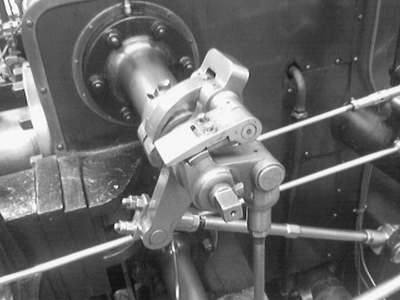

In [6]:
from PIL import Image
rgb = Image.open("pictures/valve.png")
bw = rgb.convert("L")
bw = bw.resize((400,300),Image.ANTIALIAS)
bw

In the cell below, we have a simple 1-D edge detection filter. We use this filter on the image above.

So that we don't hang the Linux Kernel engine, we chunk the image into 1000 elements per transfer.

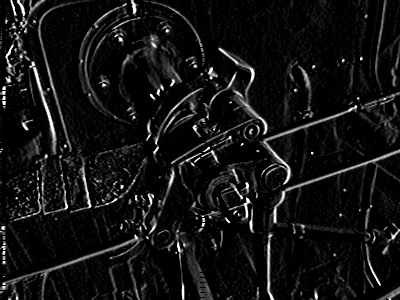

In [7]:
coeffs = [0, 0, -1, -2, 0, 2, 1, 0, 0]
sig = list(bw.getdata())
output = []
for i in range(0, len(sig), 1000):
    output += overlay.run(coeffs, sig[i : i + 1000])

out = Image.new(bw.mode, bw.size)
out.putdata(output)
out

And that's it! 

In the **[Packaging an Overlay](5-Packaging-an-Overlay.ipynb)** notebook we will make a Python Installation script!